# Исследование сервиса аренды самокатов GoFast

Предоставленные данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализивароть данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала необходимо будет проверить некоторые гипотезы.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует
    - стоимость одной минуты поездки — 8 рублей
    - стоимость старта (начала поездки) — 50 рублей
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц
    - стоимость одной минуты поездки — 6 рублей
    - стоимость старта — бесплатно
    
<font size=+1><b>Описание данных:</b></font><br>
В основных данных есть информация о пользователях, их поездках и подписках.

<font size=+0.5><b>Пользователи</b></font><br>
Данные о пользователях приложения users_go.csv
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

<font size=+0.5><b>Поездки</b></font><br>
Данные о всех поездках пользователей rides_go.csv
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

<font size=+0.5><b>Подписки</b></font><br>
Данные о стоимости подписки в приложении subscriptions_go.csv
- `subscription_type` - тип подписки (free, ultra)
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

<font size=+0.5><b>План работы:</b></font><br>
- Загрузить и изучить данные
- Найти и изучить пропуски в данных
- Выделить номер месяца 
- Выделить и обработать аномалии в данных
- Изучить информацию о пользователях и поездках:
    - частота встречаемости городов
    - соотношение пользователей с подпиской и без подписки
    - возраст пользователей
    - расстояние, которое пользователь преодолел за одну поездку
    - продолжительность поездок
- Выделить данные о пользователях без подписки и с подпиской
- Получить информацию о расстоянии и времени поездок для пользователей обеих категорий
- Выделить общую информацию по каждому пользователю за каждый месяц:
    - суммарное расстояние
    - количество поездок
    - суммарное время
    - Помесячную выручку, которую он принёс
- Проверить три гипотезы:
    - тратят ли пользователи с подпиской больше времени на поездки
    - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает ли 3130 метров (оптимальное с точки зрения износа самоката)
    - будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

In [2]:
# Цветовая палитра графиков
cmap_table='coolwarm'
cmap_plot = 'Set3'

In [3]:
# функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset, sep=',')
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient(cmap_table))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для построения гистограммы + боксплот
def first_hist(data, column, h_bins):
    plt.subplot(1,2,1)
    x_lim_min = data[column].min()
    x_lim_max = np.percentile(data[column], 99)
    data[column].plot(figsize=(20, 8),
                      kind='hist',
                      grid=True,
                      bins=h_bins)
    plt.ylabel('Количество поездок')
    plt.xlabel(column)
    plt.subplot(1,2,2)
    data[column].plot(figsize=(20, 8),
                      kind='box', 
                      grid=True)
    plt.show();

In [6]:
# функция для подписи на графике
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i]), ha = 'center')

In [7]:
# функция для построения графиков
def bar_plot(data, col_group):
    return data.plot(x=col_group,
              kind='bar',
              figsize=(20, 8),
              grid=True,
              legend=False,
              cmap=cmap_plot)

In [8]:
# функция для построения графиков
def scatter_plot(data, col_x, col_y):
    return data.plot(x=col_x, y=col_y,
                     kind='scatter',
                     figsize=(20, 8),
                     grid=True,
                     alpha=0.02)

In [9]:
# функция для построения гистограммы + боксплот для категорий
def subscription_hist(data2, column):
    plt.subplot(1,2,1)
    sns.histplot(x=column, data=data2, hue='subscription_type', palette=cmap_plot)
    sns.set(rc={'figure.figsize':(15, 5)})
    sns.set_style('whitegrid')  
    plt.xlabel(column)
    plt.ylabel('Количество поездок')
    plt.legend(['Без подписки', 'С подпиской'])

    plt.subplot(1,2,2)
    sns.boxplot(x='subscription_type', y=column, data=data2, palette=cmap_plot)
    sns.set_style('whitegrid')  
    plt.xlabel('Тип подписки')
    plt.ylabel(column)
    plt.show();

### Основная информация о пользователях

Посмотрим на основную информацию из таблицы о пользователях.

In [10]:
users = main_info('users_go.csv')

user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

31

- В таблице 5 столбцов и 1565 записей с информацией о пользователях. 
- В таблице нет пропущенных значений, но зато есть 31 строчка явных дубликатов. 
- Предварительно можно отметить, что самокаты на прокат берут молодые люди
- Средний возраст пользователя составляет 25 лет, и все пользовали в основном находятся в возврасте от 22 до 28 лет.

### Основная информация о поездках

Посмотрим на основную информацию из таблицы о поездках.

In [11]:
rides = main_info('rides_go.csv')

user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице 4 столбца и 18068 записей с информацией о поездках. 
- В таблице нет пропущенных значений и явных дубликатов.
- В некоторых столбцах присуствуют аномалии или выбросы:
    - минимальное расстояние дистанции поездки 1 м, а максимальное 7 км, при том, что медиана находится на 3.1 км
    - минимальное значение продолжительности поездки 0.5 мин

### Основная информация о подписках

Посмотрим на основную информацию из таблицы о подписках пользователей.

In [12]:
subscriptions = main_info('subscriptions_go.csv')

subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице записано всего 2 строчки, в которых содержится информация о параметрах для пользования самокатом с подпиской и без.

### Промежуточные выводы:

- В таблице с информацией о пользователях 5 столбцов и 1565 строк записей. 
- В таблице нет пропущенных значений, но зато есть 31 строчка явных дубликатов.
- Средний возраст пользователя составляет 25 лет, и все пользовали в основном находятся в возврасте от 22 до 28 лет.
- В таблице с информацией о поездках 4 столбца и 18068 строк записей. 
- В таблице нет пропущенных значений и явных дубликатов.
- Основная часть поездок по расстоянию находится от 2.5 до 3.7 км.
- Основная часть поездок по длительности сессии находится от 13 до 21 минуты.
- В некоторых столбцах присуствуют аномалии или выбросы.
- В таблице с информацией о подписках всего 2 строчки, в которых содержится информация о параметрах для пользования самокатом с подпиской и без.

## Предобработка данных

### Обработка дубликатов

Ни в одной из таблиц нет пропущенных данных. Но в таблице с пользователями есть 31 строчка явных дубликатов. Удалим такие строчки из датафрейма.

In [13]:
# Переменная для контроля % удалённых значений
del_value = [0, users.shape[0]]

In [14]:
users = users.drop_duplicates().reset_index(drop=True)
del_value[0] = users.shape[0]

Проверим количество уникальных id пользователей.

In [15]:
print('Количество строк в таблице с пользователями:', users.shape[0])
print('Количество уникальных id пользователей:', users['user_id'].nunique())

Количество строк в таблице с пользователями: 1534
Количество уникальных id пользователей: 1534


Количество уникальных id пользователей совпадает с размерностью таблицы. Значит, все оставшиеся строчки уникальны.

### Проверка на неявные дубликаты

Проверим данные на неявные дубликаты.

In [16]:
print('Города пользователей:', users['city'].unique())
print('Тип подписки:', users['subscription_type'].unique())

Города пользователей: ['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']
Тип подписки: ['ultra' 'free']


Данные представлены для 8 уникальных городов и двух типов подписок, так что неявных дубликатов нет. Для всех остальных таблиц наличие неявных дубликатов не представляется возможным. 

Изменим тип данных в таблице с датой для удобства работы с этим столбцом.

In [17]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Посмотрим, за какой период времени предоставлены данные.

In [18]:
print('Минимальная дата:',rides['date'].min())
print('Максимальная дата:',rides['date'].max())

Минимальная дата: 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Данные представленны только за 1 год: ровно за 12 месяцев с 1 января по 30 декабря 2021 года, поэтому можно спокойно выделить месяц каждой поездки.

In [19]:
rides['month'] = rides['date'].dt.month

### Проверка на аномалии

Посмотрим на возможные аномалии в данных.

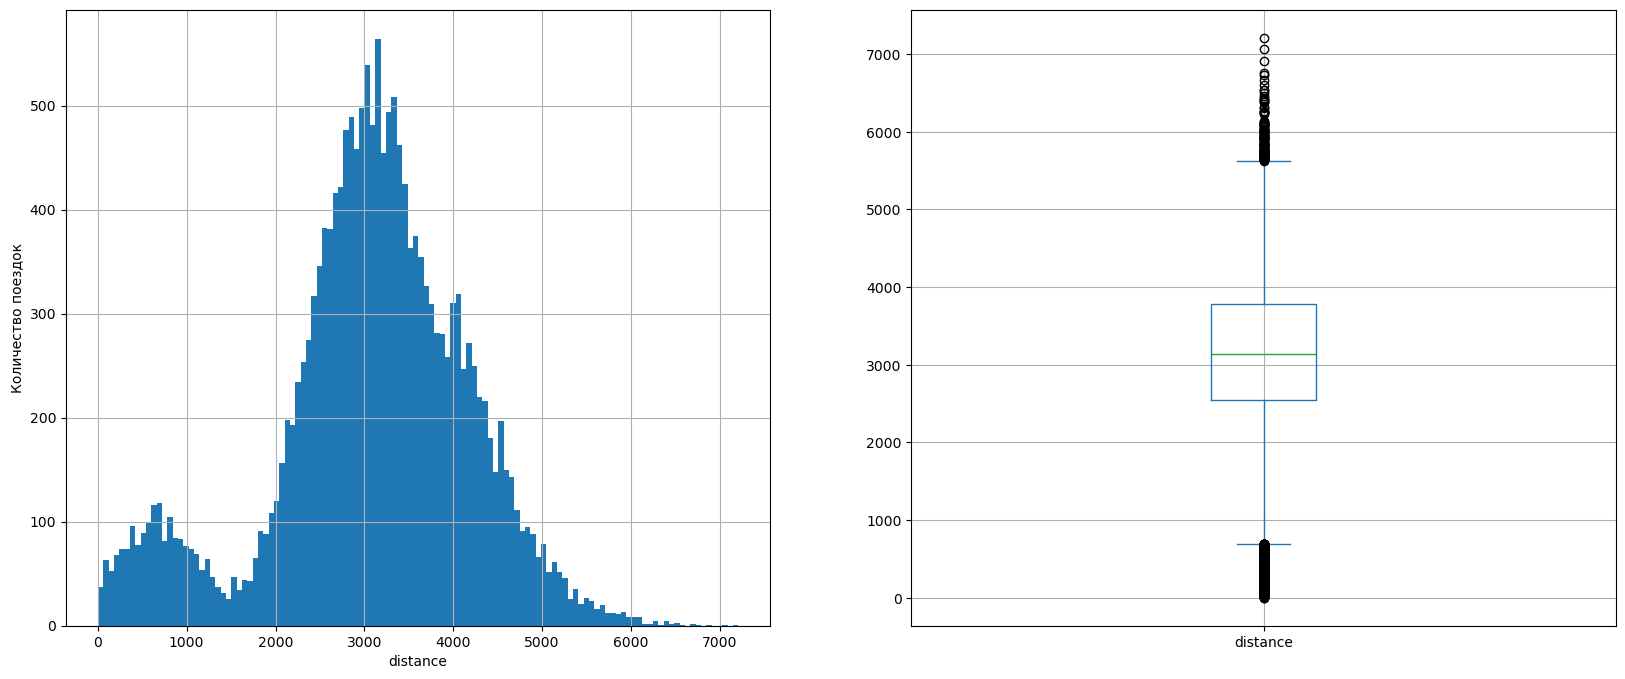

In [20]:
first_hist(data=rides, column='distance', h_bins=120)

In [21]:
print('95 и 99 перцентиль для дистанции поездки: ', 
      "{0:.1f}".format(np.percentile(rides['distance'], 95)), ', '
      "{0:.1f}".format(np.percentile(rides['distance'], 99)))

95 и 99 перцентиль для дистанции поездки:  4740.1 , 5478.6


Медианное значение расстояния за 1 поездку равняется чуть больше 3 км, а всё, что меньше 800 м или больше 5.6 км считается выбросами. 99 перцентиль равняется 5.5 км, в 95 - 4.7 км. По гистограмме видно, что есть два максимума: один в области медианного значения, второй - до 1 км (в области 600 м). В целом, никаких аномальных выбросов по гистограмме не видно.

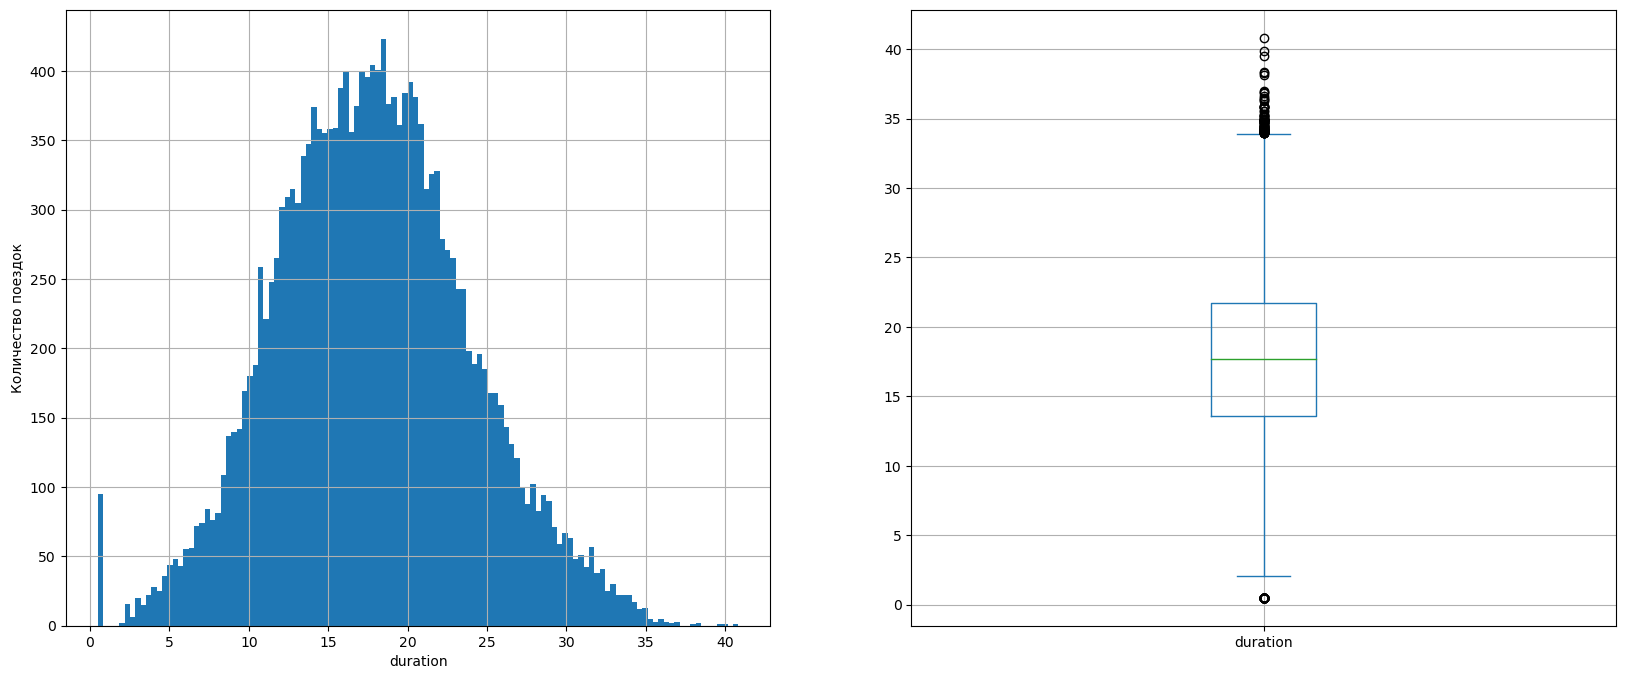

In [22]:
first_hist(data=rides, column='duration', h_bins=120)

In [23]:
print('95 и 99 перцентиль для длительности поездки: ', 
      "{0:.1f}".format(np.percentile(rides['duration'], 95)), ', '
      "{0:.1f}".format(np.percentile(rides['duration'], 99)))

95 и 99 перцентиль для длительности поездки:  28.4 , 32.5


Медианное значение времени за 1 поездку равняется 18 мин, а всё, что меньше 2 мин или больше 34 мин считается выбросами. 99 перцентиль равняется 28 мин, а 95 - 32.5 мин. По гистограмме видно, что помимо основного максимума в области медианного значения, есть ещё ряд выбросов около 1 мин (целый столбик значений). Это очень похоже на аномалии. Посмотрим на них внимательнее.

In [24]:
rides.query('duration < 1').head()

user_id     distance  duration       date  month
6531      701  4196.445201       0.5 2021-08-31      8
6570      704  4830.824371       0.5 2021-10-14     10
6680      712  4684.004397       0.5 2021-03-04      3
6695      713  5215.642710       0.5 2021-02-25      2
6768      718  5197.436649       0.5 2021-02-11      2

In [25]:
print('Количество поездок по длительности меньше 1 минуты: ', 
      rides.query('duration < 1')['user_id'].count())

Количество поездок по длительности меньше 1 минуты:  95


Таких значений 95 штук и они выглядят максимально нереалистично. Продолжительность во всех строчках составляет 0.5 мин, а при этом дистанция, которую проехал самокат - больше 4 км. Очень похоже на баг в данных. Но эти строчки удалять не будем, так как за них могла начисляться плата пользователю (на оплату имеет влияние время поездки, а не пройденное расстояние).

In [26]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  2.0%


Получим общую информацию о данных. Убедимся, что предобработка выполнена успешно.

In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [28]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


### Промежуточные выводы:

Была проведена предобработка данных.
- В таблицах не было пропусков данных, зато в таблице с пользователями была 31 строчка явных дубликатов.
- Удалённые данные составили 2% от всех данных в таблице.
- Неявных дубликатов и пропусков значений в таблицах не было.
- Тип данных в столбце с датой был приведён к соответствующему типу данных.
- В таблицу был добавлен новый столбец с номером месяца.
- На гистограмме расстояния поездок присутствовало 2 максимума: в области 600 м и 3 км. Аномальных значений не наблюдалось.
- На гистограмме длительности поездок был 1 максимум: 18 мин. Были аномальные выбросы: продолжительность составляла 0.5 мин, а дистанция при этом - 4 км.
- Аномальные значения было принято оставить, так как их удаление может повлиять на расчёт стоимости поездок пользователей.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Возраст пользователей

Первым рассмотрим возраст пользователей.

In [29]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

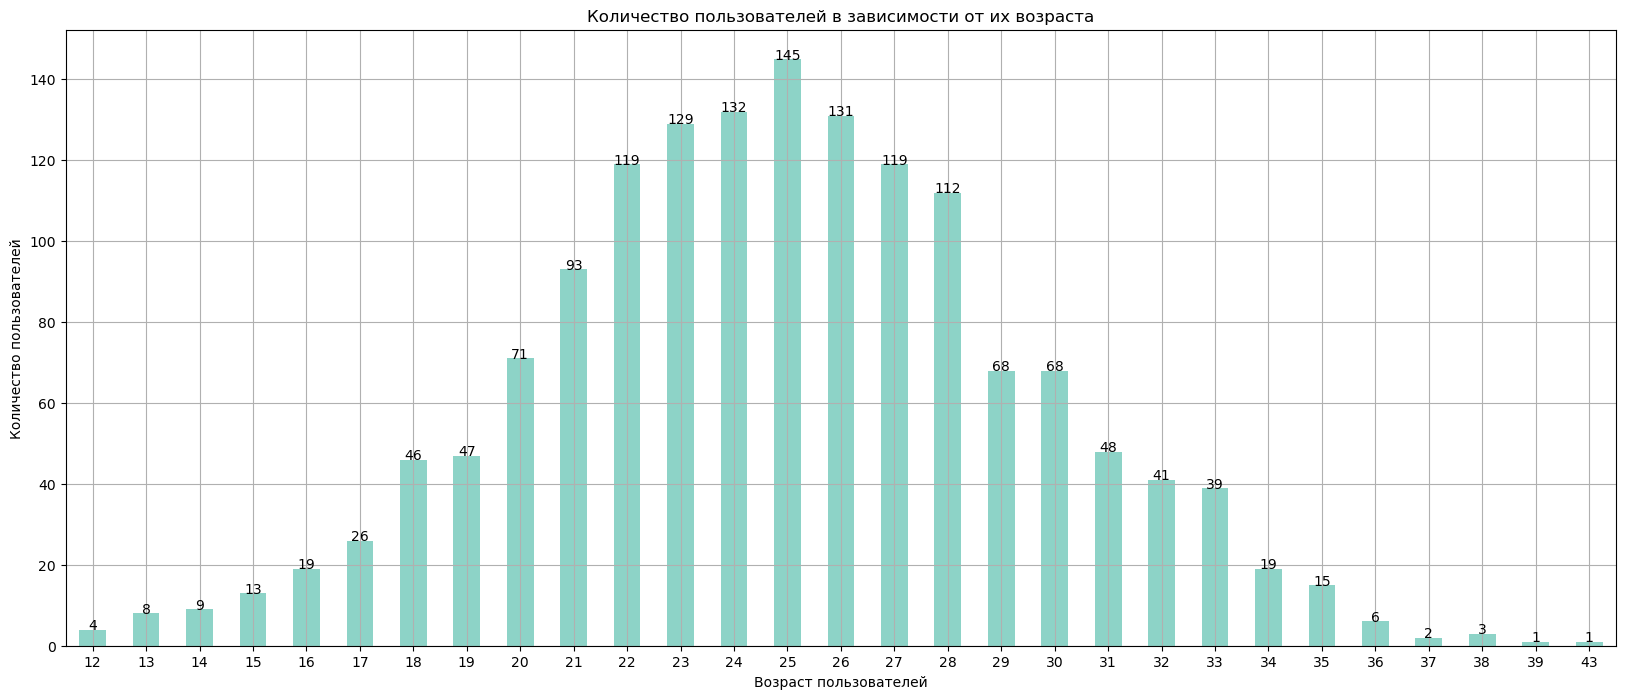

In [30]:
df = table_pivot(data=users, col_group='age', values='age', func='count')
fig = bar_plot(data=df, col_group='age')
plt.xticks(rotation=0)
addlabels(x=df['age'], y=df['total'])
plt.xlabel('Возраст пользователей')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей в зависимости от их возраста')
plt.show();

Возраст пользователей находится от 12 до 43 лет. Медианное значение приходится на 25 лет, а основная масса пользователей находится в возрасте от 22 до 28 лет. В данных представлено 1534 уникальных пользователя, что является хорошей выборкой.

### Частота встречаемости городов

Далее рассмотрим частоту встречаемости городов.

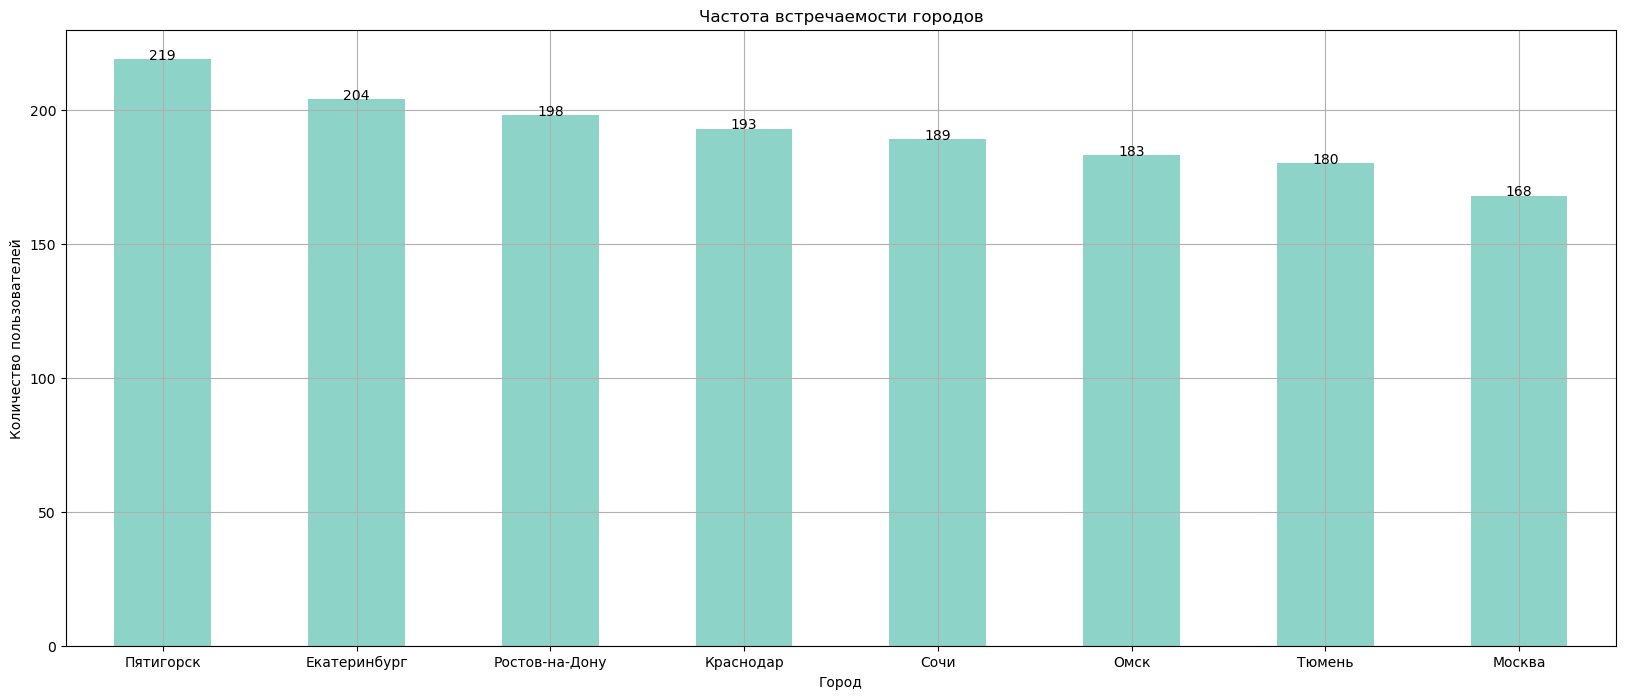

In [31]:
df = table_pivot(data=users, col_group='city', values='city', func='count')\
                .sort_values(by='total',ascending=False)\
                .reset_index(drop=True)
fig = bar_plot(data=df, col_group='city')
plt.xticks(rotation=0)
addlabels(x=df['city'], y=df['total'])
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.title('Частота встречаемости городов')
plt.show();

Больше всего пользователей из Пятигорска, а из Москвы меньше всего. Но, в целом, представлены равнозначные группы для анализа от 160 до 220 пользователей в каждой группе. Так что процент пользователей, приходящийся на каждый город, не сильно отличается для разных городов.

Но, если посмотреть на разницу по количеству населения в этих городах (в Москве 13 млн жителей, в Пятигорске 149 тыс), то можно однозначно утверждать, что в Пятигорске использовать самокат востребованее, чем в Москве. И отчасти это может быть потому, что в Москве более интенсивное движение и хорошо развит общественный транспорт, поэтому пользоваться прокатом самокатов не очень удобно, в отличии от более спокойного Пятигорска. Но тут надо дополнительно сравнивать районы, в которых катаются на самокатах, длительность пробега поездок и другие факторы, чтобы подтвердить эту гипотезу.

### Пользователи с подпиской и без

Посмотрим на соотношение пользователей с подпиской и без.

In [32]:
users_type = table_pivot(data=users, col_group='subscription_type', values='user_id', func='nunique')
users_type['part_subscript'] = users_type['total'] / users_type['total'].sum()
users_type.style.format({'part_subscript': '{:.1%}'})

In [33]:
fig = go.Figure(data=[go.Pie(labels=users_type['subscription_type'], 
                             values=users_type['total'])])
fig.update_layout(
                  title='Доля подписок',
                  title_x = 0.5
                 )
fig.show();

Пользователей без подписки больше, примерно на 150 человек, чем пользователей с подпиской. В целом, это небольшая разница, всего 9% по отношению к общему количеству пользователей.

### Расстояние поездок

Построим более точную гистрограмму для дистанции поездки.

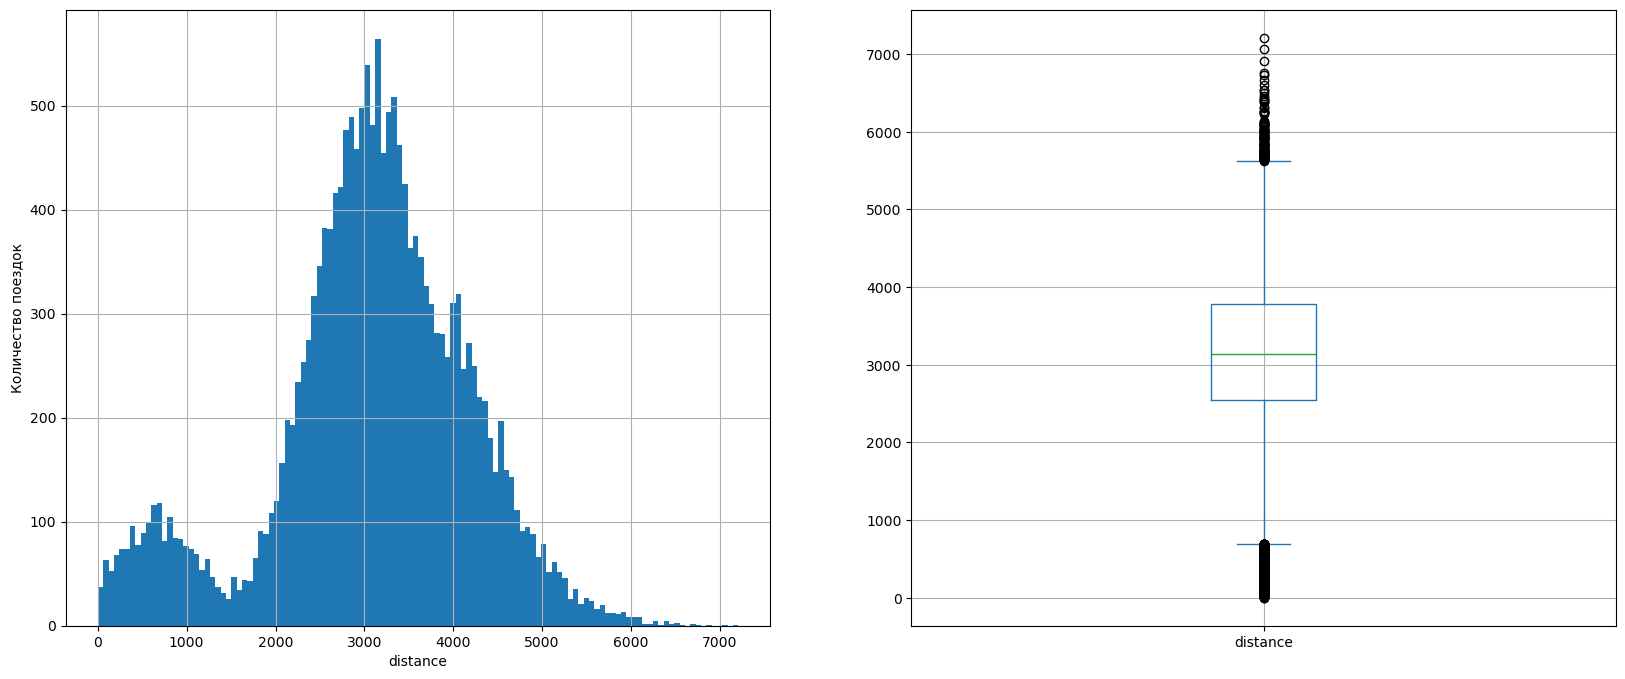

In [34]:
first_hist(data=rides, column='distance', h_bins=120)

In [35]:
print('Процент расстояний за одну поездку, меньше 200 м: ', 
      "{0:.1%}".format(rides.loc[rides['distance'] <= 200, 'distance'].count() \
                        / rides['distance'].count()))

Процент расстояний за одну поездку, меньше 200 м:  0.9%


Видно, что у распределения есть два максимума: один в области медианного значения 3 км, второй - в области 600 м. И при этом есть значения близкие к нулю. Значения меньше 200 м выглядят сомнительно (вряд ли кто-то берёт самокат, чтобы прокатиться меньше минуты, а 200 м как раз соответствуют примерно 1-2 минутам езды). Но, с другой стороны, ограничения по минимальной дистанции, которую мог проехать пользователь, не существует. Вполне вероятна ситуация, когда он оплатил поездку, но не стал кататься, так как что-то произошло. В целом, таких значений по отношению к основной массе данных, не велико: меньше 1 %. Для гистограммы значения меньше 800 м и больше 5.5 км считаются выбросами.

### Время поездок

Посмотрим на график длительности поездки.

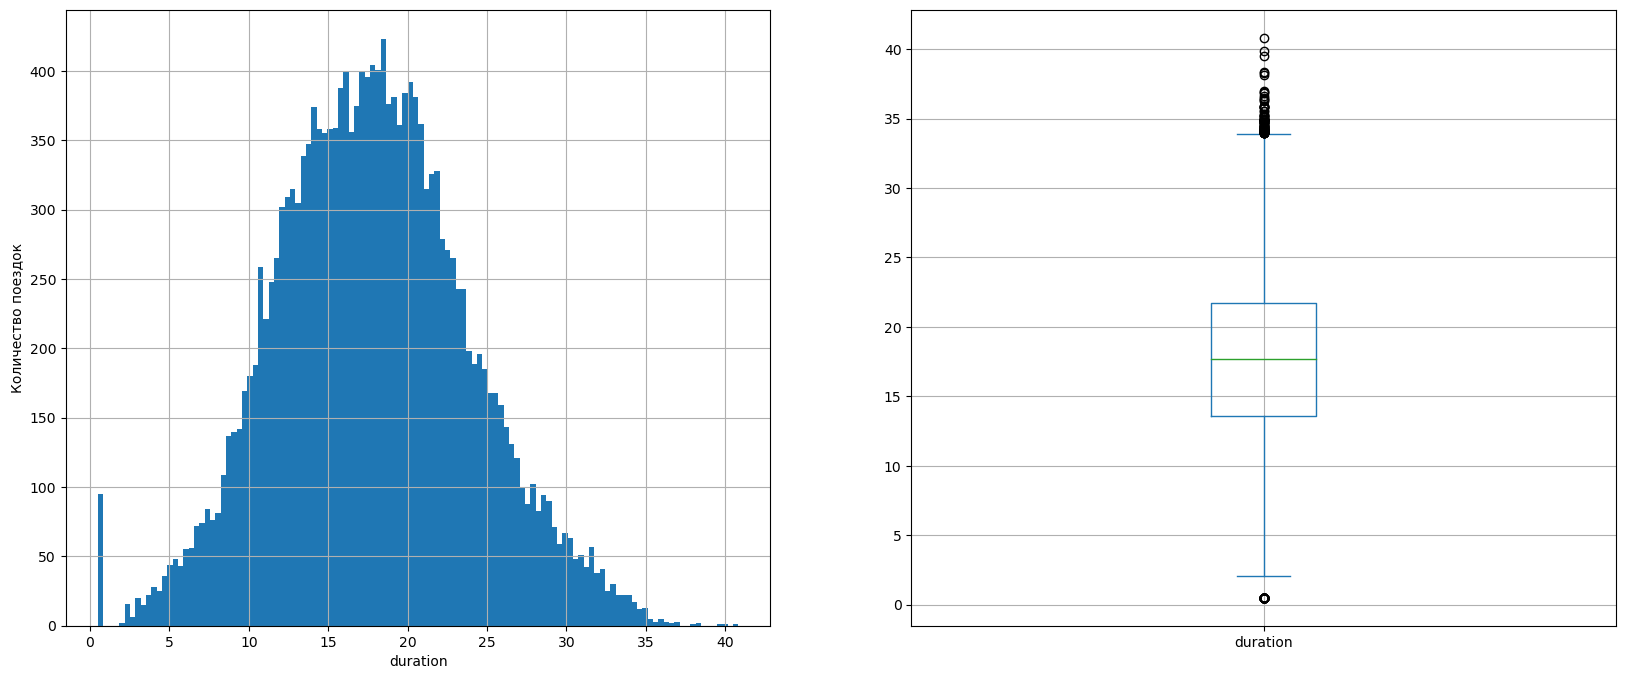

In [36]:
first_hist(data=rides, column='duration', h_bins=120)

In [37]:
print('Процент времени за одну поездку, меньше 2х минут: ', 
      "{0:.1%}".format(rides.loc[rides['duration'] <= 2, 'duration'].count() \
                        / rides['duration'].count()))

Процент времени за одну поездку, меньше 2х минут:  0.5%


Медианное время длительности поездок составляет 18 мин, при этом основная масса поездок сосредоточена от 14 до 22 мин. Всё, что выше 34 минут считается выбросами. Также можно отметить, что нет поездок короче двух минут, кроме тех 95 штук, которые считаются выбросами и меньше 1% от всех данных.

### Скорость поездок

Посмотрим на график скорости поездок.

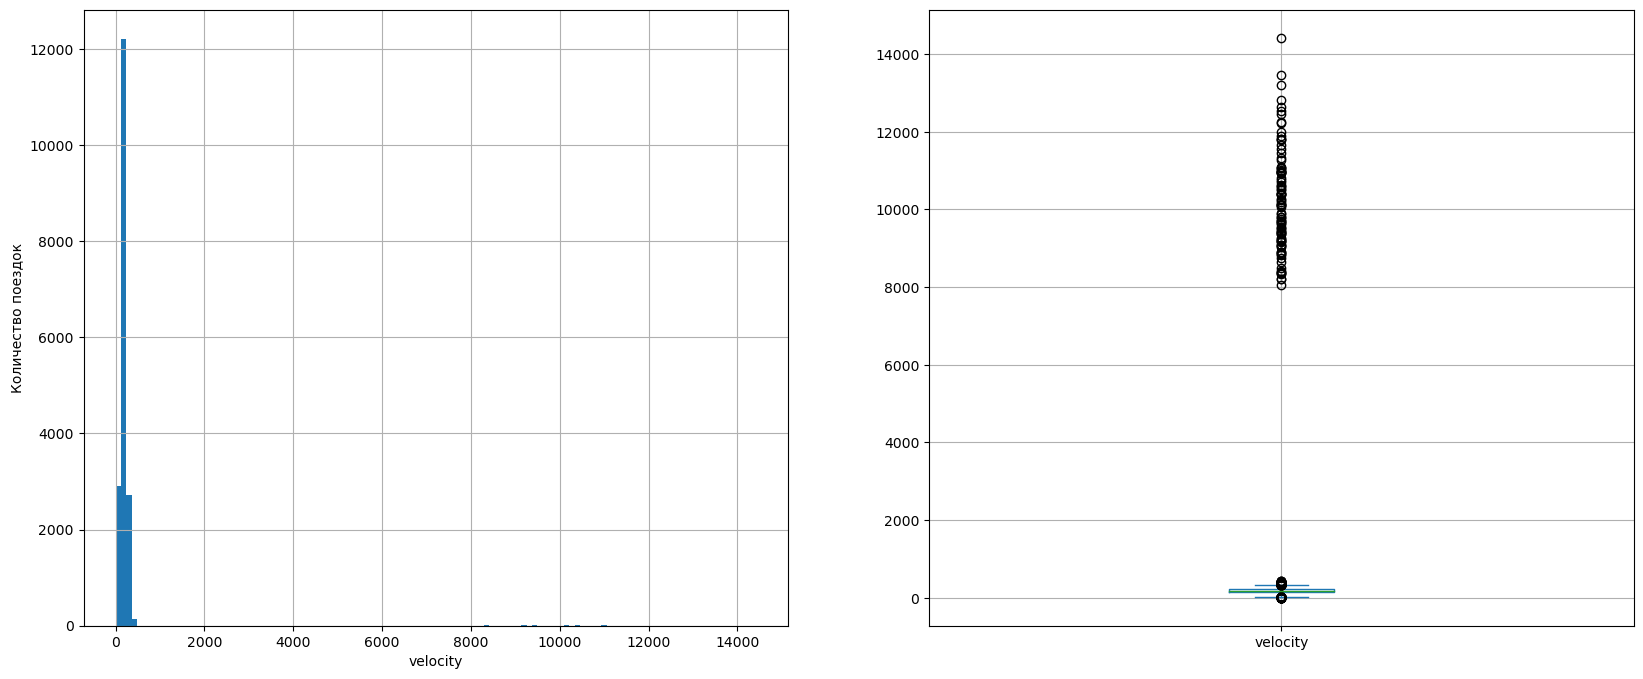

In [38]:
rides['velocity'] = rides['distance'] / rides['duration']
first_hist(data=rides, column='velocity', h_bins=120)

Из-за аномалий по времени в 0.5 мин, когда была зафиксирована большая дистанция (более 4х км) на графике присутствуют большие выбросы. Посмотрим гистограмму более подробно.

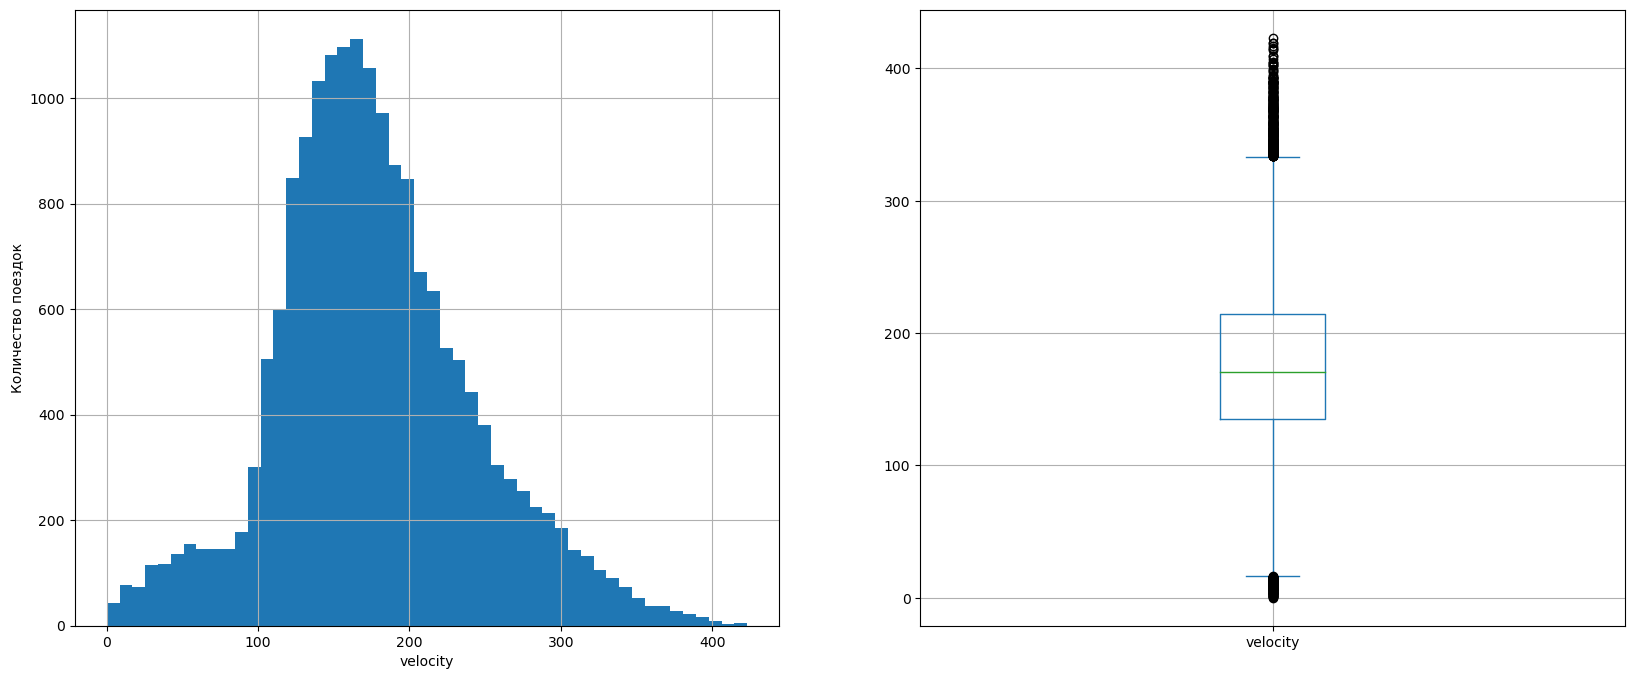

In [39]:
first_hist(data=rides.query('velocity < 500'), column='velocity', h_bins=50)

In [40]:
print('Процент скоростей, меньше средней скорости ходьбы человека: ', 
      "{0:.1%}".format(rides.loc[rides['velocity'] <= 100, 'velocity'].count() \
                        / rides['velocity'].count()))

Процент скоростей, меньше средней скорости ходьбы человека:  8.6%


На гистограмме средней скорости езды (дистанция, пройденная самокатом, делённая на время поездки) видно, что максимум скорости приходится на 160 м/с, а хвост справа уходит к 400 м/с, что согласуется с реальными данными по скорости езды на самокатах. При этом хвост в левой части не затухает, есть значения близкие к 0 м/с. Но, можно увидеть, что значений средней скорости меньше ходьбы (100 м/с) меньше 9 % от всех данных.

*Средняя скорость ходьбы человека составляет 4-6 км/ч, т.е. 80-100 м/мин. Очень медленная ходьба составляет 2 км/ч, т.е. 35 м/мин. Средняя скорость обычного, не электрического, самоката: 15-20 км/ч, т.е. 250-330 м/мин. Средняя скорость электросамоката для взрослых: 35 км/ч, что равняется 580 м/мин.*

Посмотрим на числовые значения для средней скорости.

In [41]:
rides['velocity'].describe()

count    18068.000000
mean       229.754352
std        735.936479
min          0.085552
25%        135.464046
50%        170.852249
75%        215.496668
max      14422.015489
Name: velocity, dtype: float64

Основная масса по скорости сосредоточена от 135 м/мин до 215 м/мин. При этом аномалии из-за нереалистичного времени поездки (4 км за 0.5 мин) считаются выбросами на графике и находятся в отдельной области на боксплоте.

Посмотрим на зависимость скорости поездки от пройденного расстояния (без учёта аномальных значений).

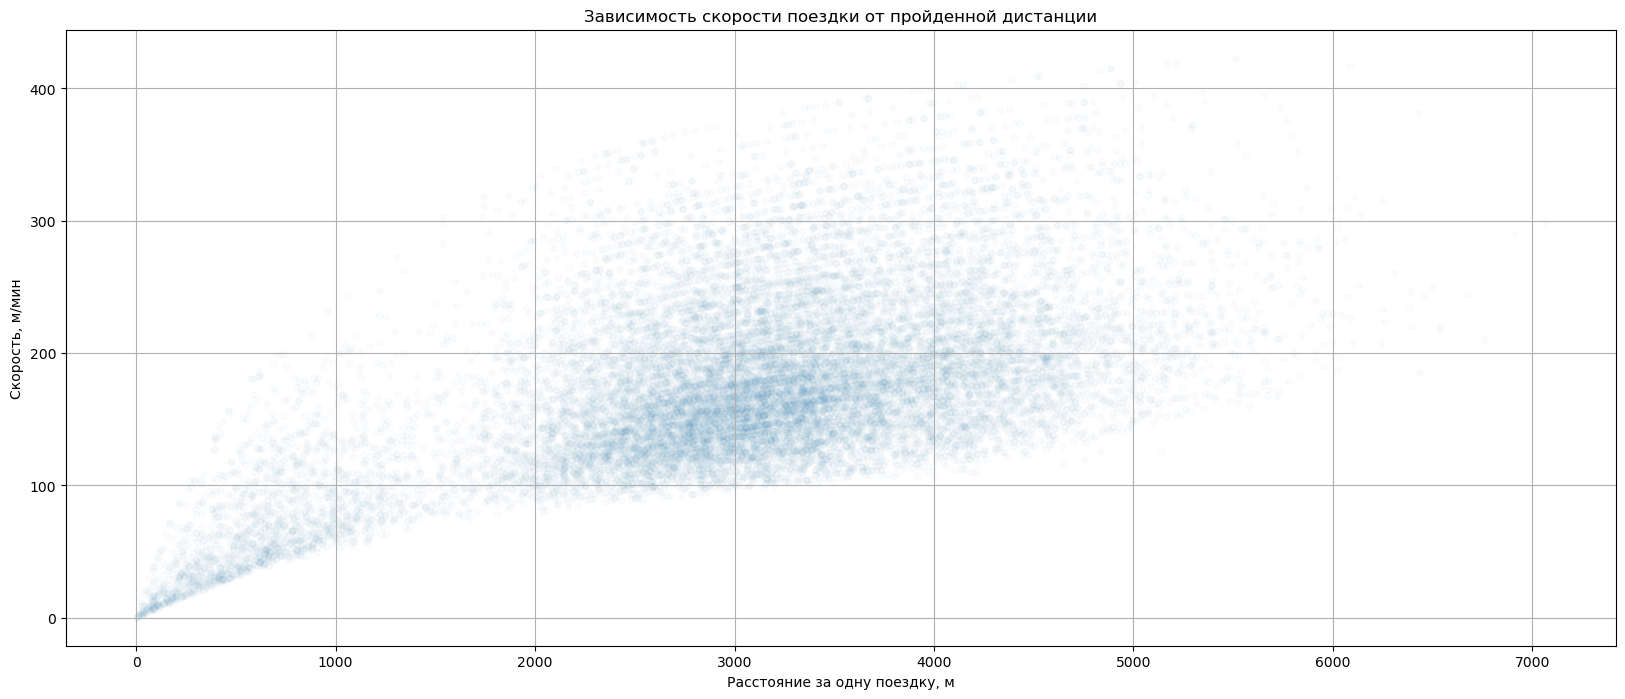

In [42]:
fig = scatter_plot(data=rides.query('velocity < 500'), col_x='distance', col_y='velocity')
plt.xlabel('Расстояние за одну поездку, м')
plt.ylabel('Скорость, м/мин')
plt.title('Зависимость скорости поездки от пройденной дистанции')
plt.show();

Большая масса точек сосредоточена в области от 100 до 200 м/ мин от 2 до 4 км. Второе пятно точек от 0 до 1 км для скорости меньше 100 м/ мин. При этом можно отметить, что график зависимости не линейный. Поначалу скорость движения растёт прямо пропорционально пройденному расстоянию, но чем больше дистанция, тем лучше скорость выходит на пороговое значение чуть больше 200 м/ мин. Это может быть объяснено тем, что мало кто берёт самокат, чтобы кататься без остановок. Чем дольше пройденная дистанция за 1 поездку, тем чаще человек делает привалы.

Также можно посмотреть на зависимость скорости поездки от длительности поездки в минутах (без учёта аномальных значений).

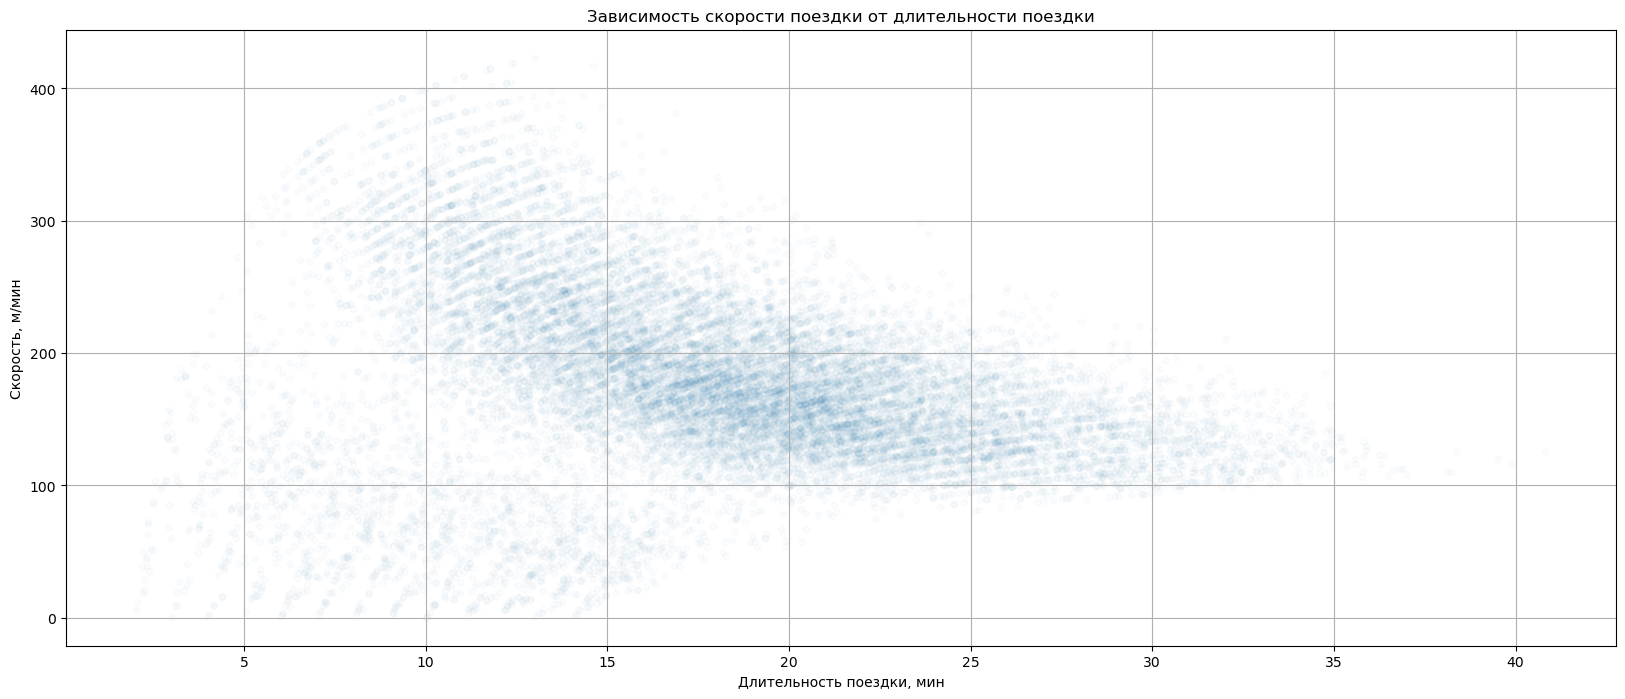

In [43]:
fig = scatter_plot(data=rides.query('velocity < 500'), col_x='duration', col_y='velocity')
plt.xlabel('Длительность поездки, мин')
plt.ylabel('Скорость, м/мин')
plt.title('Зависимость скорости поездки от длительности поездки')
plt.show();

Основная масса точек находится 12 до 25 минут при скорости 100-200 м/ мин. И, чем больше длительность поездки, тем сильнее падает скорость движения (но не ниже 100 м/ мин). Можно предположить, что при коротких по времени поездках, пользователь более интенсивно использует самокат (меньше останавливается на отдых, из-за чего средняя скорость движения остаётся высокой). При более длительных по времени поездках пользователь чаще останавливается, из-за чего снижается средняя скорость за всё время поездки.

### Промежуточные выводы:

Была проанализирована общая информация о пользователях и поездках, такая как: частота встречаемости городов, соотношение пользователей с подпиской и без, возраст пользователей, расстояние и время одной поездки. 

- Медианное значение возраста пользователя приходится на 25 лет, а основная масса пользователей находится в возрасте от 22 до 28 лет, т.е. самокаты используют в основном молодые люди, которые уже сами зарабатывают себе на жизнь (22 года - возраст либо уже работающего человека, либо последние курсы университета, когда также возможна подработка параллельно с учёбой).
- В Пятигорске больше пользователей самокатов, а в Москве меньше всего. Это может быть связано с доступностью и количеством общественного транспорта, количеством парков, темпом жизни. 
- Процент пользователей, приходящийся на каждый город, не сильно отличается для разных городов.
- Пользователей, которые не используют подписку, всего на 9 % меньше, чем с подпиской относительно общего количества пользователей. 
- Медианное значение расстояния одной поездки составляет чуть больше 3 км. При этом основное расстояние поездок сосредоточено от 2.5 км до 3.8 км. 
- Значение расстояний согласуется с медианным временем одной поездки, которое составило 17 мин. Основная масса поездок по длительности сосредоточена от 14 до 22 мин.
- Значений по средней скорости самоката за поездку, которые были бы меньше средней скорости ходьбы человека, всего 9 % от общего количества поездок. Этот процент будет меньше, если учесть, что, чем больше по времени составляет длительность поездки, тем больше вероятность, что пользователь остановится на отдых, и средняя скорость его движения будет снижена.

## Объединение данных

Соединим датафреймы, чтобы потом выделить отдельно пользователей с подпиской и без. 

In [44]:
# Размерность датафрейма поездок
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
 5   velocity  18068 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 847.1 KB


In [45]:
data = users.merge(rides, on='user_id')
data = data.merge(subscriptions, on='subscription_type')

In [46]:
# Размерность созданного датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   velocity           18068 non-null  float64       
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

Выделим отдельно информацию по пользователям с подпиской и без подписки.

In [47]:
users_free = data[data['subscription_type'] == 'free']
users_ultra = data[data['subscription_type'] == 'ultra']

### Расстояние поездок для подписчиков

Посмотрим распределение по пройденному расстоянию за одну поездку для пользователей с подпиской и без подписки.

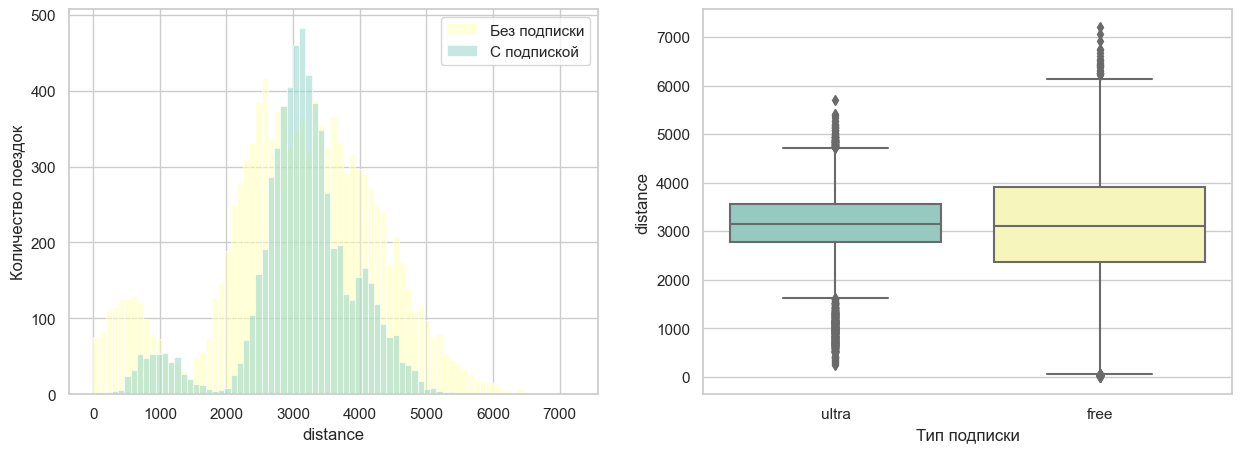

In [57]:
subscription_hist(data2=data, column='distance')

Видно, что на гистограмме пользователей с подпиской есть три максимума: в области 1 км, 3 км и 4 км, при этом медианным значением является именно 3 км. Основная масса поездок сосредоточена от 2.9 до 3.5 км, а выбросами считается всё, что меньше 1.8 и выше 4.9 км.

Для пользователей без подписки медианное значение расстояния также составляет 3 км, но при этом более широкий диапазон расстояний: от 2.3 до 4 км. А выбросами считается всё, что меньше 200 м и больше, чем 6.2 км. Это интересный диапазон, так как именно пользователи без подписки платят не только за каждую минуту пользования самокатом, но и за начало использования (стартовый сбор).

Ещё можно отметить, что у распределения поездок без подписки на гистограмме нет ярко выраженного максимума в области медианного значения, есть только диапазон в этой области, в отличии от тех, кто использует подписку.

### Время поездок для подписчиков

Посмотрим распределение по времени за одну поездку пользователей.

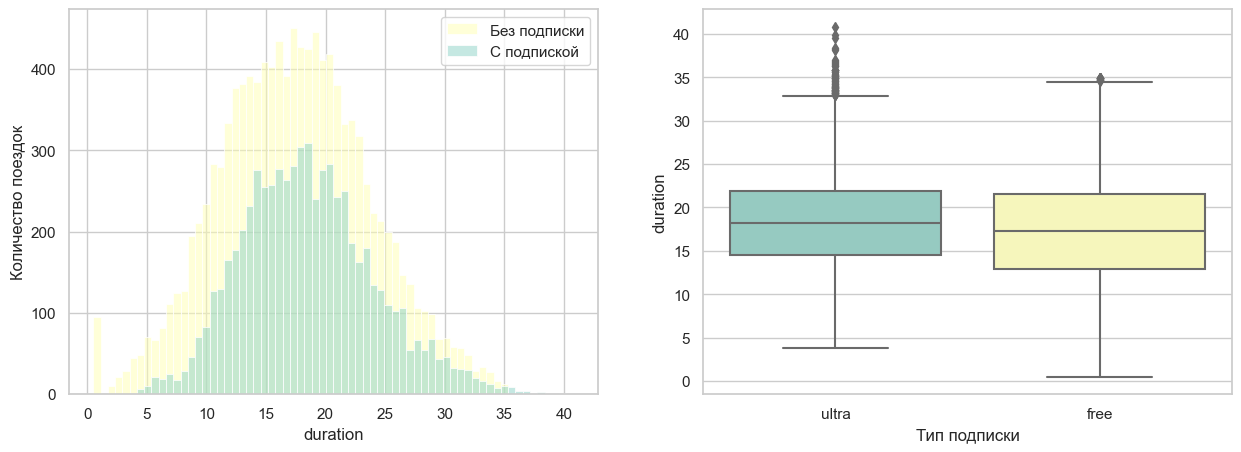

In [49]:
subscription_hist(data2=data, column='duration')

Распределения для пользователей с подпиской и без весьма схожи между собой по форме. Диапазон значений для пользователей с подпиской чуть уже и находится от 15 до 22 мин, в то время, как для пользователей без подписки - от 13 до 22 мин. Медиана для обеих категорий находится на 18 мин. Можно отметить, что для пользователей с подпиской на гистограмме нет аномального выброса для 0.5 мин, значит, он присутствует только для пользователей без подписки.

### Промежуточные выводы:

- Отдельно были выделены пользователи с подпиской и без неё. 
- Была рассмотрена дальность и длительность поездки для каждой из категорий. 
- Медианное значение расстояния для обеих категорий составило 3 км, но при этом на графике людей с подпиской были видны два других максимума: в области 1 км и 4 км. 
- Для пользователей без подписки для расстояния поездки более широкий разброс значений от медианного, распределение имеет более широкую форму и имеет дополнительный максимум в области 500 м.
- По времени одной поездки распределения схожи между собой для обеих категорий.
- Медианное значение времени поездки для обеих категорий составило 18 мин.
- Для пользователей с подпиской отсутствовал аномальный выброс на 0.5 мин, он присутствовал только для пользователей без подписки.

## Подсчёт выручки

Объединим данные для подсчёта месячной выручки от каждого пользователя. Округлим длительность каждой поездки до целого числа сверху.

In [50]:
data['duration'] = np.ceil(data['duration'])
data['duration'] = data['duration'].astype('int64')

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   velocity           18068 non-null  float64       
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(3)
memory 

Создадим сводную таблицу по каждому пользователю с подпиской за каждый месяц.

In [52]:
data_income = data.groupby(by=['user_id', 'month'], as_index=False)\
                  .agg(sessions_number = ('duration', len),
                       sessions_distance = ('distance', np.sum),
                       sessions_duration = ('duration', np.sum),
                       subscription_type = ('subscription_type', 'first'),
                       minute_price = ('minute_price', 'first'),
                       start_ride_price = ('start_ride_price', 'first'),
                       subscription_fee = ('subscription_fee', 'first'))
# Добавим в неё столбец с месячной выручкой
data_income['income'] = (data_income['start_ride_price'] * data_income['sessions_number']) \
                              + (data_income['minute_price'] * data_income['sessions_duration']) \
                              + data_income['subscription_fee']
data_income.head()    

user_id  month  sessions_number  sessions_distance  sessions_duration  \
0        1      1                2        7027.511294                 42   
1        1      4                1         754.159807                  7   
2        1      8                2        6723.470560                 46   
3        1     10                2        5809.911100                 32   
4        1     11                3        7003.499363                 56   

  subscription_type  minute_price  start_ride_price  subscription_fee  income  
0             ultra             6                 0               199     451  
1             ultra             6                 0               199     241  
2             ultra             6                 0               199     475  
3             ultra             6                 0               199     391  
4             ultra             6                 0               199     535

### Промежуточные выводы:

- Для дальнейшего удобства работы с данными была создана сводная таблица по каждому пользователю и его статистика за месяц.

## Проверка гипотез

Проверка гипотез будет проводиться t-тестом с уровнем статистической значимости 0.05.

In [53]:
# Задаём уровень значимости
alpha = 0.05

### Тратят ли подписчики больше времени на поездки

Проверим первую гипотезу о том, кто тратит больше времени на поездки: пользователи с подпиской или без.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Нет различия для средних значений по времени поездок для пользователей с подпиской или без.}\\
   H_1 :\text{Среднее значение по времени поездок для пользователей с подпиской больше, чем для пользователей без подписки.}
 \end{cases}
\end{equation*}$

In [54]:
# Проверяем t-тестом разницу между средними двух выборок
results = st.ttest_ind(users_ultra['duration'], users_free['duration'], alternative='greater')

print('Среднее значение продолжительности поездки для пользователей без подписки: ', \
      "{0:.1f}".format(users_free['duration'].mean()))
print('Среднее значение продолжительности поездки для пользователей с подпиской: ', \
      "{0:.1f}".format(users_ultra['duration'].mean()))

print('p-значение:', "{0:.3}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

Среднее значение продолжительности поездки для пользователей без подписки:  17.4
Среднее значение продолжительности поездки для пользователей с подпиской:  18.5
p-значение: 1.28e-34
Отвергаем нулевую гипотезу: между группами есть значимая разница


Отклоняем гипотезу о том, что средние значения времени поездки на самокате для подписчиков и людей без подписки равны в пользу гипотезы о том, что подписчики тратят больше времени на поездки. Вполне вероятно, что люди с подпиской хотят окупить для себя траты на ежемесячную подписку, что стимулирует их брать самокат на прокат чаще.

### Проезжает ли подписчик расстояние меньше оптимального

Расстояние одной поездки в 3130 м оптимально с точки зрения износа самоката. Проверим вторую гипотезу о том, пользователи с подпиской за одну поездку проезжают расстояние не больше оптимального.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Среднее значение расстояния одной поездки пользователя с подпиской равно 3130 м.}\\
   H_1 :\text{Среднее значение расстояния одной поездки пользователя с подпиской не равно 3130 м.}
 \end{cases}
\end{equation*}$

In [55]:
# Проверяем t-тестом среднее значение для расстояния одной поездки подписчиков
distance_optimal = 3130
results = st.ttest_1samp(users_ultra['distance'], distance_optimal)

print('Оптимальное значение дальности поездки для износа самоката: ', \
      "{0:.1f}".format(distance_optimal))
print('Среднее значение дальности поездки для пользователей с подпиской: ', \
      "{0:.1f}".format(users_ultra['distance'].mean()))

print('p-значение:', "{0:.3}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

Оптимальное значение дальности поездки для износа самоката:  3130.0
Среднее значение дальности поездки для пользователей с подпиской:  3115.4
p-значение: 0.161
Не отвергаем нулевую гипотезу


Как видно из проведённого t-теста, отвергать нулевую гипотезу нельзя. Пользователь с подпиской в среднем катается оптимально для степени износа самоката, т.е. не больше оптимального значения.

### Помесячная выручка от пользователей с подпиской и без

Проверим третью гипотезу о том, месячная выручка от пользователей с подпиской выше, чем от пользователей без.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние значения месячной выручки от пользователей с подпиской или без одинаковы.}\\
   H_1 :\text{Среднее значение месячной выручки для пользователей с подпиской больше, чем для пользователей без подписки.}
 \end{cases}
\end{equation*}$

In [56]:
# Проверяем t-тестом разницу между средними двух выборок
results = st.ttest_ind(data_income.loc[data_income['subscription_type'] == 'ultra', 'income'], \
                       data_income.loc[data_income['subscription_type'] == 'free', 'income'], \
                       alternative='greater')
print('Среднее значение ежемесячных трат на самокаты для пользователей без подписки: ', \
      "{0:.1f}".format(data_income.loc[data_income['subscription_type'] == 'ultra', 'income'].mean()))
print('Среднее значение ежемесячных трат на самокаты для пользователей с подпиской: ', \
      "{0:.1f}".format(data_income.loc[data_income['subscription_type'] == 'free', 'income'].mean()))

print('p-значение:', "{0:.3}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

Среднее значение ежемесячных трат на самокаты для пользователей без подписки:  362.8
Среднее значение ежемесячных трат на самокаты для пользователей с подпиской:  328.6
p-значение: 1.89e-31
Отвергаем нулевую гипотезу: между группами есть значимая разница


Как видно из проведённого t-теста, гипотеза о том, что помесечная выручка от пользователей с подпиской равняется выручке без подписки оказалась не верна и отвергается в пользу альтернативной гипотезы, в которой говорится, что месячная выручка от подписчиковы выше, чем от пользователей без подписки. Таким образом, люди с подпиской ежемесячно приносят компании больше денег. И, соответственно, стимул для пользователей переходить на вариант с подпиской является хорошим планом.

### Промежуточные выводы:

Было проверено несколько гипотез касательно трат пользователей на услуги аренды самокатов. 
- В среднем за месяц пользователи с подпиской тратят больше время на катание на самокате, чем пользователи без подписки. 
- Помесячная выручка от пользователей с подпиской выше, чем от тех, у кого подписки нет. 
- Это является хорошей возможностью начать стимулировать больше пользователей переходить на подписку. 
- В среднем за поездку пользователь проезжает расстояние, которое является оптимальным с точки зрения износа самоката, но не меньше этого значения. 
- Можно задуматься о том, чтобы пересмотреть оплату каждой минуты поездки для пользователей, если окажется, что обслуживание самоката по себестоимости будет дороже, чем ожидалось.

## Итоги исследования

Было проведено исследование сервиса аренды самокатов GoFast. Были предоставлены данные о пользователях из нескольких городов и об их поездках. Необходимо было проанализивароть данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Такие как: как часто пользователи с подпиской пользуются прокатом самоката в месяц, приносят ли пользователи с подпиской больше дохода компании за месяц, используют ли клиенты с подпиской самокат так, чтобы это было оптимально с точки зрения износа самоката.

Перед анализом, данные были подготовлены для корректной работы:
- Было загружено 3 таблицы с данными о пользователях, их поездках и стоимости подписок.
- В таблицах не было пропусков данных.
- В таблице с пользователями были удалены 31 явный дубликат.
- Неявных дубликатов в таблицах не было.
- В столбце с длительностью поездки были найдены и удалены аномальные значения (было зафиксировано, что пользователь за 0.5 мин проехал более 4 км).
- Удалённые данные составили 2% от всех данных в датафрейме.
- Был добавлен отдельный столбец с номером месяца для каждого использования самоката.
- Данные подготовлены для дальнейшего анализа.

Была проанализирована общая информация о пользователях и поездках, такая как: частота встречаемости городов, соотношение пользователей с подпиской и без, возраст пользователей, расстояние и время одной поездки. 

- Медианное значение возраста пользователя приходится на 25 лет, основная масса пользователей находится в возрасте от 22 до 28 лет, т.е. самокаты используют в основном молодые люди.
- В Пятигорске больше пользователей самокатов, а в Москве меньше всего. В целом, в каждом из 8 представленных к анализу городов количество пользователей не сильно отличалось друг от друга и колебалось в пределах 10 %.
- Пользователей, которые не используют подписку, всего на 9 % меньше, чем с подпиской относительно общего количества пользователей. 
- Медианное значение расстояния одной поездки составляет чуть больше трёх км. При этом основное расстояние поездок сосредоточено от 2.5 км до 3.8 км. 
- Значение расстояний согласуется с медианным временем одной поездки, которое составило 17 мин. Основная масса поездок по длительности сосредоточена от 14 до 22 мин.
- Значений по средней скорости самоката за поездку, которые были бы меньше средней скорости ходьбы человека, всего 9 % от общего количества поездок.

Были выделены отдельно пользователи с подпиской и без неё. Была рассмотрена дальность и длительность поездки для каждой из категорий:
- Медианное значение расстояния для подписчиков и клиентов без подписки составило 3 км, при этом на графике с подпиской были явно обозначены два других максимума: в области 1 км и 4 км. 
- Для пользователей без подписки присутствовал более широкий разброс значений от медианного, распределение имело более широкую форму и дополнительный максимум в области 500 м. 
- По времени одной поездки графики распределения для пользователей с подпиской и без схожи между собой и не имели особых различий.

Было проверено несколько гипотез касательно трат пользователей на услуги аренды самокатов:
- В среднем за месяц пользователи с подпиской тратят больше время на катание на самокате, чем пользователи без подписки. 
- Помесячная выручка от пользователей с подпиской выше, чем от тех, у кого подписки нет.
- За одну поездку в среднем клиент с подпиской проезжает расстояние, которое является оптимальным с точки зрения износа самоката, но не гарантированно меньше этого значения, он может проезжать и расстояние немного больше.

Таким образом, можно подвести общий итог: 
- Пользователи, у которых есть подписка на прокат самокатов являются выгодными клиентами с точки зрения прибыли для компании.
- Пользователи, у которых есть подписка тратят на поезди больше времени, а, значит, приносят больше денег с каждой минуты пользования самокатом.
- При этом можно учесть, что чем длинее по времени поездка, тем чаще пользователь останавливается на отдых и не использует самокат по назначению. А значит срок службы самоката резко не укорачивается.